In [1]:
import numpy as np
import pandas as pd
#import matplotlib as mpl
import matplotlib.pyplot as pl
#import matplotlib.cm as cm
#import matplotlib.colors as mcolors
#from matplotlib.ticker import FormatStrFormatter
#pl.style.use('classic')
import re                    # Extract number from line text

#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.width', None)

In [2]:
#+++++++++++++++++Functions+++++++++++++++++#

    # Read Log data file, find the last line and extract total time run. Make this for all arrays used in sbatch.
    # Returns an array with times (in minutes) for all arrays used in sbatch.
def Total_Time_Run(directory, Arr_Used, Job_name_base, Nsim):
    T_Run = []
    for i in Arr_Used:
        file_name = directory+'/'+Job_name_base+str(i) # Path for the log-file
    
        with open(file_name) as file:
            for line in file:
                pass
            last_line = line # Find last line (this line has the total run time)
            file.close()
            # Divide in 60*Nsim: Nsim sims made, 60 to convert seconds to minutes)
        time = np.asarray(re.findall(r'[+-]?\d+(?:\.\d+)?', last_line), dtype=np.float32)/(60*Nsim)
        T_Run.append(time[0])
    return T_Run

    # Extract interest data for statitiscal analysis. Take data for N(t) in each array job.
def DT_exctract(DT, col_name, Nsim):
    Output = pd.DataFrame()
    Aux = np.empty(Nsim)
    for j in range(len(DT)):
        for i in range(Nsim):
            col = col_name+str(i+1)
            Aux[i] = DT[col][j]
        Aux1 = pd.DataFrame([Aux])
        Output = pd.concat([Output, Aux1], ignore_index=True)

    return Output

    # Makes statistical analysis for number particles and time.
def Stat_Analysis(Time_Dat, N_Dat):
    N_t = pd.DataFrame(columns=['t', 'N_avg', 'std_N', 'log_t', 'log_N'])
    for i in range(len(Time_Dat)):
        t = Time_Dat.iloc[i, 1:].mean()
        if t != 0:
            t_log = np.log(t)
        else:
            t_log = 0.0
        N = N_Dat.iloc[i, 1:].mean()
        N_std = N_Dat.iloc[i, 1:].std()
        if N != 0:
            N_log = np.log(N)
        else:
            N_log = 0.0
        Aux = pd.DataFrame([[t, N, N_std, t_log, N_log]], columns=['t', 'N_avg', 'std_N', 'log_t', 'log_N'])
        N_t = pd.concat([N_t, Aux], ignore_index=True)
    return N_t

In [3]:
#+++++++++++++++++Parameters+++++++++++++++++#

N = 100
Nsim = 10
beta = 0.5
lf = 1.0

Arr_Used = np.arange(0,100) # Number of arrays used in sbatch: 0 - 99

Directory for log-files:

NXX_NiterXXX_NsimXX_betaXXX_dtXXX_lfXXX

File name for extract total time run:

real_fusion_job.o8936_XX

XX is the SLURM_ARRAY_TASK_ID: 0 -- 99

Total time is in end line of file as:

Total time for make all simulations XXXXX.XXXXXXXXXXX

Time XXXXX.XXXXXXXXXXX is in seconds. Convert to minutes.

In [4]:
#+++++++++++++++++Read and extract interest data for N(t)+++++++++++++++++#

TTR = pd.DataFrame(columns=['dt', 'Time', 'Std_Time']) # Time and Std_Time in minutes

    # 1st round:
dt1 = 0.0001
Niter1 = 1000000
Job_Id1 = 8936

directory1 = 'N'+str(N)+'_Niter'+str(Niter1)+'_Nsim'+str(Nsim)+'_beta'+str(beta)+'_dt'+str(dt1)+'_lf'+str(lf)
Job_name_base1 = 'real_fusion_job.o'+str(Job_Id1)+'_'

T1 = Total_Time_Run(directory1, Arr_Used, Job_name_base1, Nsim)
TR_1 = pd.DataFrame([[dt1, np.mean(T1), np.std(T1)]], columns=['dt', 'Time', 'Std_Time'])
TTR = pd.concat([TTR, TR_1], ignore_index=True)

    # 2nd round:
dt2 = 1e-5
Niter2 = 10000000
Job_Id2 = 9045

directory2 = 'N'+str(N)+'_Niter'+str(Niter2)+'_Nsim'+str(Nsim)+'_beta'+str(beta)+'_dt'+str(dt2)+'_lf'+str(lf)
Job_name_base2 = 'real_fusion_job.o'+str(Job_Id2)+'_'

T2 = Total_Time_Run(directory2, Arr_Used, Job_name_base2, Nsim)
TR_2 = pd.DataFrame([[dt2, np.mean(T2), np.std(T2)]], columns=['dt', 'Time', 'Std_Time'])
TTR = pd.concat([TTR, TR_2], ignore_index=True)

    # 3rd round:
dt3 = 1e-6
Niter3 = 100000000
Job_Id3 = 9145

directory3 = 'N'+str(N)+'_Niter'+str(Niter3)+'_Nsim'+str(Nsim)+'_beta'+str(beta)+'_dt'+str(dt3)+'_lf'+str(lf)
Job_name_base3 = 'real_fusion_job.o'+str(Job_Id3)+'_'

T3 = Total_Time_Run(directory3, Arr_Used, Job_name_base3, Nsim)
TR_3 = pd.DataFrame([[dt3, np.mean(T3), np.std(T3)]], columns=['dt', 'Time', 'Std_Time'])
TTR = pd.concat([TTR, TR_3], ignore_index=True)

TTR

,dt,Time,Std_Time
0,0.0001,1.878478,0.157924
1,0.00001,19.362762,1.572775
2,0.000001,201.943649,19.628839


In [30]:
#+++++++++++++++++Statistical analysis for N(t)+++++++++++++++++#

'''col_name_t = 't_' # To extract only time fusion data
col_name_N = 'N_' # To extract only number particle data

Stat = pd.DataFrame()
for i in Arr_Used:
    DT = pd.read_csv(directory3+'/Nsimst_'+str(i)+'/N_t.csv')
    T = DT_exctract(DT, col_name_t, Nsim) # Change between col_name_N and col_name_t to select N and t data only
    Stat = pd.concat([Stat, T], axis=1, ignore_index=True)

Stat.to_csv(directory3+'/All_Sims_t.csv') # Change between All_Sims_N and All_Sims_t to save N and t data only'''


DT_t1 = pd.read_csv(directory1+'/All_Sims_t.csv')
DT_N1 = pd.read_csv(directory1+'/All_Sims_N.csv')

DT_t2 = pd.read_csv(directory2+'/All_Sims_t.csv')
DT_N2 = pd.read_csv(directory2+'/All_Sims_N.csv')

DT_t3 = pd.read_csv(directory3+'/All_Sims_t.csv')
DT_N3 = pd.read_csv(directory3+'/All_Sims_N.csv')

N_t1 = Stat_Analysis(DT_t1, DT_N1)
N_t2 = Stat_Analysis(DT_t2, DT_N2)
N_t3 = Stat_Analysis(DT_t3, DT_N3)

N_t1.to_csv(directory1+'.csv')
N_t2.to_csv(directory2+'.csv')
N_t3.to_csv(directory3+'.csv')



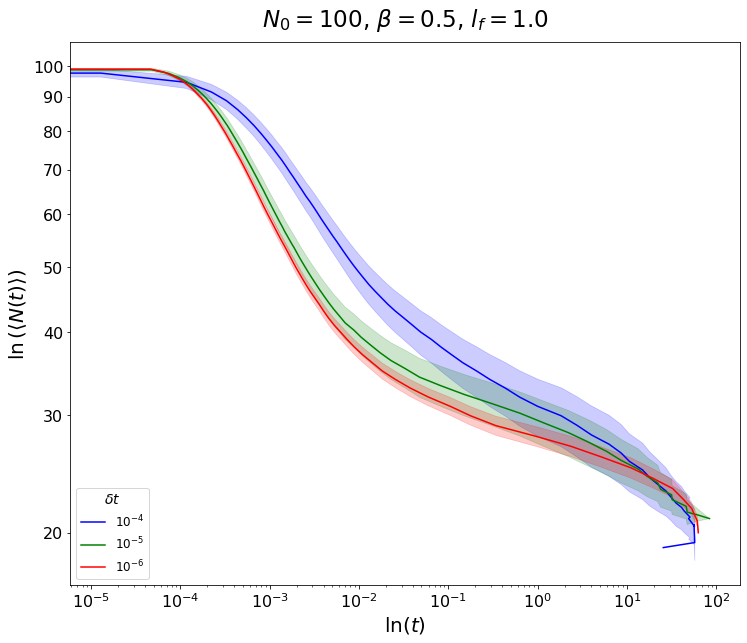

In [32]:
#+++++++++++++++++N(t) plot+++++++++++++++++#

pl.rcParams["figure.figsize"] = [12, 10]

    # 1st Round
x1 = np.array(N_t1['t'], dtype=float)
y1 = np.array(N_t1['N_avg'], dtype=float)
y1_err = np.array(N_t1['std_N'], dtype=float)

    # 2nd Round
x2 = np.array(N_t2['t'], dtype=float)
y2 = np.array(N_t2['N_avg'], dtype=float)
y2_err = np.array(N_t2['std_N'], dtype=float)

    # 3rd Round
x3 = np.array(N_t3['t'], dtype=float)
y3 = np.array(N_t3['N_avg'], dtype=float)
y3_err = np.array(N_t3['std_N'], dtype=float)

Tit = r'$N_0 = $'+str(N)+r', $\beta = $'+str(beta)+r', $l_f = $'+str(lf)
figname = 'Ninit'+str(N)+'_beta'+str(beta)+'_lf'+str(lf)+'.pdf' # To save plot

fig = pl.figure()

ax = pl.axes(xscale = 'log', yscale = 'log')
pl.xlabel(r'$\ln(t)$', fontsize = 20)
pl.ylabel(r'$\ln\left(\langle N(t) \rangle\right)$', fontsize = 20)
pl.title(Tit, fontsize = 23, pad = 15)
pl.xticks(fontsize = 16)
pl.yticks(fontsize = 16)
locs, labels = pl.yticks()
pl.yticks(np.arange(0, N+10, 10), np.arange(0, N+10, 10))
pl.plot(x1, y1, label=r'$10^{-4}$', c='blue')
pl.fill_between(x1, y1+y1_err, y1-y1_err, alpha = 0.2, linewidth = 0.75, color='blue')
pl.plot(x2, y2, label=r'$10^{-5}$', c='green')
pl.fill_between(x2, y2+y2_err, y2-y2_err, alpha = 0.2, linewidth = 0.75, color='green')
pl.plot(x3, y3, label=r'$10^{-6}$', c='red')
pl.fill_between(x3, y3+y3_err, y3-y3_err, alpha = 0.2, linewidth = 0.75, color='red')
pl.legend(title=r'$\delta t$', loc='lower left', fontsize=12, title_fontsize=14)
pl.show()
fig.savefig(figname, dpi = 500)
pl.close(fig)

In [35]:
#+++++++++++++++++Functions+++++++++++++++++#

def time_df(dt, N_iter, steps):
    tf = N_iter*dt
    t_df = pd.DataFrame([(t) for t in np.geomspace(dt, tf, steps)], columns = ['t'])
    return t_df

def empty_Q_hist(Niter, Nsim, dt, N, Qmax, steps):
    Charge_Cols = [] # Column names for stat. analysis of charge distributions
    for q in range(Qmax):
        Charge_Cols.append('Q'+str(q+1))
    hists_out = time_df(dt, Niter, steps)
    Cols_Charges = pd.DataFrame(np.zeros((len(hists_out), Qmax)), columns=Charge_Cols)

    hist_out = pd.concat([hists_out, Cols_Charges], axis=1)
    return hist_out

def empty_Q_pd(Niter, Nsim, dt, N, Qmax, steps):
    Charge_Sim = [] # Column names for stat. analysis of charge distributions
    for sim in range(Nsim):
        for q in range(Qmax):
            Charge_Sim.append('Sim'+str(sim+1)+'Q'+str(q+1))

    hists_out = time_df(dt, Niter, steps)
    Cols_Charges = pd.DataFrame(np.zeros((len(hists_out), Nsim*Qmax)), columns=Charge_Sim)

    hist_out = pd.concat([hists_out, Cols_Charges], axis=1)
    return hist_out

def decompress_data_Q(compressed_hists, N, Qmax, Niter, Nsim, dt, steps):
    hists_out = empty_Q_pd(Niter, Nsim, dt, N, Qmax, steps)
    for sim in range(Nsim):
        for i, line in enumerate(compressed_hists[sim]):
            s, t_now, (hist, bins) = compressed_hists[sim][i]
            if i < len(compressed_hists[sim])-1:
                tf = compressed_hists[sim][i+1][1]
            else:
                tf = Niter*dt
            for idx, Q in enumerate(hist):
                col_name = 'Sim'+str(sim+1)+'Q'+str(idx+1)
                hists_out.loc[(t_now <= hists_out['t']) & (hists_out['t'] <= tf), [col_name]] = Q
    return hists_out

def Q_extract(hists, sim):
    T_sim = len(hists[sim])
    H = pd.DataFrame()
    for t in range(T_sim):
        s, t_now, (hist, bins) = hists[sim][t]
        qs = np.array(np.nonzero(hist))+1
        n_qs = np.array(hist[np.nonzero(hist)], dtype=float)
        cols = np.append(['t'], qs[0])
        n_qs = np.insert(n_qs, 0, t_now, axis=0)
        H_aux = pd.DataFrame([n_qs], columns=cols)
        H = pd.concat([H, H_aux], ignore_index=True)
    return H

def Prepare_data(DT, dt, Niter, steps):
    hists_out = time_df(dt, Niter, steps)
    Cols = np.append(['t'], np.arange(1, len(DT.columns)))
    H_out = pd.DataFrame(columns=Cols)
    H_out = pd.concat([H_out, hists_out])

    for t in range(len(DT)):
        t_now = DT['t'][t]
        n_q = np.array(DT.iloc[t:t+1, 1:], dtype=float)
        if t < len(DT)-1:
            tf = DT['t'][t+1]
        else:
            tf = Niter*dt
        for q in range(len(n_q[0])):
            col_name = str(q+1)
            H_out.loc[(t_now <= H_out['t']) & (H_out['t'] <= tf), [col_name]] = n_q[0][q]
    return H_out

In [ ]:
#+++++++++++++++++Read and extract interest data for Q(t)+++++++++++++++++#
import pickle
import csv

#pd.reset_option('all')

dt1 = 1e-4
Niter1 = 1000000

steps = 100
Qmax = N

times = time_df(dt1, Niter1, steps)

for i in Arr_Used:
    hist_filename = directory1+'/Nsimst_'+str(i)+'/Q_t.pickle'
    with open(hist_filename, 'rb') as histsfile:
        hists=pickle.load(histsfile)

    for sim in range(Nsim):
        H = Q_extract(hists, sim)
        H_out = Prepare_data(H, dt1, Niter1, steps)
        for idx in range(len(H_out)):
            time = H_out['t'][idx]
            with open(directory1+'/QT_Analysis/QT_dt'+str(time)+'.csv', 'a+') as f:
                f = csv.writer(f, delimiter=',')
                for q in np.array(H_out.iloc[idx:idx+1, 1:]):
                    f.writerow(q)
